In [1]:
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import random
import os
import numpy as np
import torch
import sys

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
sys.path.append('../utils')

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED)

In [5]:
from training_nn import training, training_rnn
from evaluation import evaluate_model, plot_loss, evaluate_model_rnn
from process_data import get_desc, get_data
from models import CNN, RNN, RNNembed
from dataset import Abencode1, Abencode2, OnehotandAB, Onehot

In [6]:
train_path = '../dataset/phys_train.csv'
test_path = '../dataset/phys_test.csv'

In [7]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [8]:
train.head()

,junction_aa,v_call,consensus_count,j_call,clonal_frequency,Label,Distance,Antibody,repr
0,KNEGFNCYIPLVTYGFHTTTGVSY,IGHV_RBD,1,IGHJ_RBD,0.000028,0,7,LY16,[[ 0.0000000e+00 0.0000000e+00 0.0000000e+00...
1,KNKGFNCYSPITEYGFFPTNGKNF,IGHV_RBD,2,IGHJ_RBD,0.000093,1,9,LY16,[[ 0.0000000e+00 0.0000000e+00 0.0000000e+00...
2,SKQGFNCYCPLIGYGFQRTFGVGW,IGHV_RBD,1,IGHJ_RBD,0.000028,0,9,LY16,[[ 0.0000000e+00 0.0000000e+00 0.0000000e+00...
3,KNRQFNCYWPLVRYGFWTTSGVGW,IGHV_RBD,1,IGHJ_RBD,0.000028,0,9,LY16,[[ 0.0000000e+00 0.0000000e+00 0.0000000e+00...
4,KNPGFNCYLPLGHYGFQPTNGRDF,IGHV_RBD,3,IGHJ_RBD,0.000140,1,7,LY16,[[ 0.00000000e+00 0.00000000e+00 0.00000000e...


In [15]:
train['repr'] = get_desc(train)
test['repr'] = get_desc(test)

In [18]:
train.head()

,junction_aa,v_call,consensus_count,j_call,clonal_frequency,Label,Distance,Antibody,repr
0,KNEGFNCYIPLVTYGFHTTTGVSY,IGHV_RBD,1,IGHJ_RBD,0.000028,0,7,LY16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,KNKGFNCYSPITEYGFFPTNGKNF,IGHV_RBD,2,IGHJ_RBD,0.000093,1,9,LY16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,SKQGFNCYCPLIGYGFQRTFGVGW,IGHV_RBD,1,IGHJ_RBD,0.000028,0,9,LY16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,KNRQFNCYWPLVRYGFWTTSGVGW,IGHV_RBD,1,IGHJ_RBD,0.000028,0,9,LY16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,KNPGFNCYLPLGHYGFQPTNGRDF,IGHV_RBD,3,IGHJ_RBD,0.000140,1,7,LY16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [32]:
train.head()

,junction_aa,v_call,consensus_count,j_call,clonal_frequency,Label,Distance,Antibody,repr
0,KNEGFNCYIPLVTYGFHTTTGVSY,IGHV_RBD,1,IGHJ_RBD,0.000028,0,7,LY16,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,KNKGFNCYSPITEYGFFPTNGKNF,IGHV_RBD,2,IGHJ_RBD,0.000093,1,9,LY16,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,SKQGFNCYCPLIGYGFQRTFGVGW,IGHV_RBD,1,IGHJ_RBD,0.000028,0,9,LY16,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,KNRQFNCYWPLVRYGFWTTSGVGW,IGHV_RBD,1,IGHJ_RBD,0.000028,0,9,LY16,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,KNPGFNCYLPLGHYGFQPTNGRDF,IGHV_RBD,3,IGHJ_RBD,0.000140,1,7,LY16,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [37]:
train_target, valid_target, target_test, rest_df = get_data(train, test, samples = 200, target_ab = 'REGN33')

In [41]:
def prepare_dataloader(df, torch_dataset, batch_size=5, shuffle=True):
    dataset = torch_dataset(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader

In [68]:
train_loader_rest = prepare_dataloader(rest_df, torch_dataset = Abencode1, shuffle=True, batch_size=10)
validloader = prepare_dataloader(valid_target, torch_dataset = Abencode1, shuffle=False, batch_size=2)
train_loader_target = prepare_dataloader(train_target,torch_dataset = Abencode1, shuffle=True, batch_size=2)
testloader = prepare_dataloader(target_test, torch_dataset = Abencode1, shuffle=False, batch_size=10)

In [51]:
model = CNN(41, 100).to(device)

In [52]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30

In [54]:
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, train_loader_target, validloader)

100%|██████████| 30/30 [00:35<00:00,  1.18s/it]


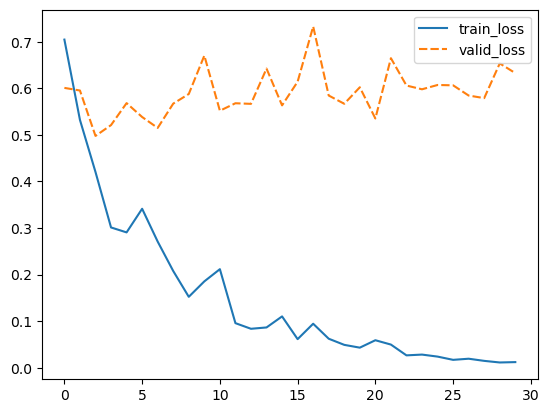

In [60]:
plot_loss(loss_train_hist, loss_valid_hist)

In [61]:
evaluate_model(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.767463,0.726878,0.790641,0.75742,0.853307


__Training base model__

In [76]:
model = CNN(41, 150).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, train_loader_rest, validloader)

100%|██████████| 30/30 [23:13<00:00, 46.45s/it]


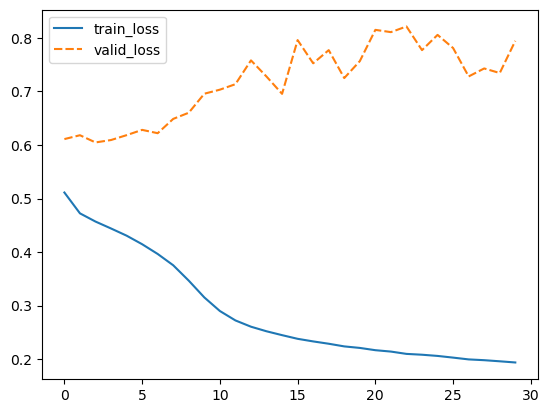

In [77]:
plot_loss(loss_train_hist, loss_valid_hist)

In [78]:
evaluate_model(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.639665,0.398441,0.768652,0.52483,0.765456


In [120]:
def copy_model(model, *args):
    model_copy = type(model)(*args)
    model_copy.load_state_dict(model.state_dict())
    return model_copy.to(device)

In [125]:
model_copy = copy_model(model, 41, 150)

In [134]:
def freeze_weights(model, name_layers=['None']):
    for name, param in model.named_parameters():
        if not any([layer in name for layer in name_layers]):
            param.requires_grad = False
    return model

In [135]:
model_copy = freeze_weights(model_copy)   # freeze all weights

In [ ]:
def add_layers(model):
    new_layers = nn.Sequential(
    nn.Linear(150, 75),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(75, 1))
    model.cl = new_layers
    return model.to(device)
    
    

In [138]:
model_copy = add_layers(model_copy)

In [144]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_copy.parameters(), lr=1e-3)
num_epochs = 40
loss_train_hist, loss_valid_hist = training(model_copy, criterion, optimizer, num_epochs, train_loader_target, validloader)

100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


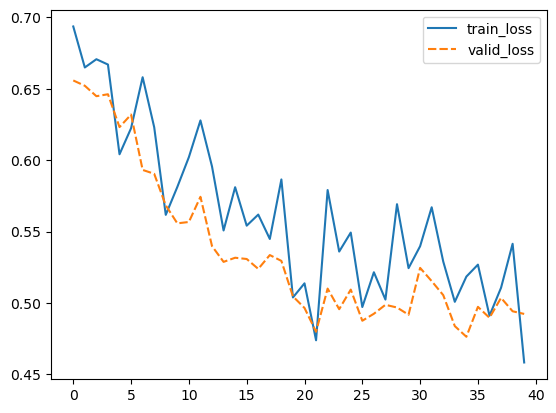

In [145]:
plot_loss(loss_train_hist, loss_valid_hist)

In [146]:
evaluate_model(testloader, model_copy)

,accuracy,recall,precision,f1_scor,auc
0,0.724115,0.500824,0.90395,0.644545,0.861503
